# Approach

1) Determine the frequency of the signal with increasing time using the Short-Time Fourier Transform.

2) From the frequency of the transmitted signal determine radial velocity of the projective using the dopler shift.

3) Make assumptions which allows the initial velocity to be determined.

4) Estimate the distance from the sensor by using the initial velocity and radial velocity.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import IPython.display
from scipy.io import wavfile

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.titleweight'] = 'bold'
    
def plot_frequency_vs_time(wav_file, window_length, frame_overlap, **kwargs):
    ''' 
    Plots the frequency vs time of a given .wav file
    using the Short-Time Fourier Transform (STFT).
    '''
    sample_freq, samples = wavfile.read(wav_file)
    T_sample = 1 / sample_freq
    f, t, stft = signal.stft(samples*T_sample, sample_freq, nperseg=window_length, noverlap=frame_overlap)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
    for ax in [ax1,ax2]:
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (s)')
    if 'title1' in kwargs:
        ax1.set_title(kwargs['title1'])

    # Plot colormap spectogram
    ax1.pcolormesh(t, f, np.abs(stft),shading='gouraud')
    if 'ylim' in kwargs:
        ax1.set_ylim(kwargs["ylim"])

    # Plot maximum frequency component
    max_freq_index = np.argmax(np.abs(stft), axis=0)
    max_freq = f[max_freq_index]
    
    # Remove data points where freq=0 and greater than the source frequency
    data = [point for point in zip(t, max_freq) if (point[1] > 0 and point[1] < 10100)]
    (t, max_freq) = zip(*data)
    
    ax2.plot(t, max_freq)
    
    if 'title2' in kwargs:
        ax2.set_title(kwargs['title2'])
        
    if 'ylim' in kwargs:
        ax2.set_ylim(kwargs["ylim"])
        
    fig.tight_layout()
    
    return t, max_freq
    
def plot_radial_velocity(time_data, freq_data, f_source, speed_of_sound = 340, **kwargs):
    '''Plot the radial velocity from the dopler shift'''
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    
    time_data = np.array(time_data)
    freq_data= np.array(freq_data)

    # Calculate velocity of receding object using the dopler shift
    change_f = f_source - freq_data
    # The change in frequency is double of what it would be if 
    # the projectile were to have been the source (one way transmission).
    # To account for the wave reflecting off of the moving object, the 
    # change in frequency has to be divided by two.
    change_f = change_f / 2
    v_radial = (change_f * speed_of_sound) / f_source

    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    else:
        ax.set_title('Radial Velocity Plot')
        
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs["ylim"])
        
    ax.plot(time_data, v_radial)
    fig.tight_layout()
    return time_data, v_radial

def plot_approximate_distance(time_data, v_radial, v_initial, interval = None, **kwargs):
    '''Plots the distance to the sensor at each time interval, given the initial velocity.'''
    if not interval is None:
        t_min, t_max = interval
        filter_data = [point for point in zip(time_data, v_radial) if (point[0] > t_min and point[0]< t_max)]
        time_data, v_radial = zip(*filter_data)
        time_data = np.array(time_data)
        v_radial = np.array(v_radial)
    
    #use vr = vx * sin(theta) to calculate theta
    theta = np.arcsin(v_radial / v_initial)
    
    #calculate ration of d(sensor) to dx
    distance_ratio = np.tan(theta)
    
    #calculate dx from initial velocity and time info
    dx = time_data * v_initial
    
    #Calculate sensor distance using the distance ratio
    d_sensor = distance_ratio * dx
    
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    else:
        ax.set_title('Estimated distance to sensor')
    ax.set_ylabel('Distance (m)')
    ax.set_xlabel('Time (s)')
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs["ylim"])
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs["xlim"])
    fig.tight_layout()
    ax.plot(time_data, d_sensor)

# Transmitted signal

Frequency of transmitted signal is 10 kHz.

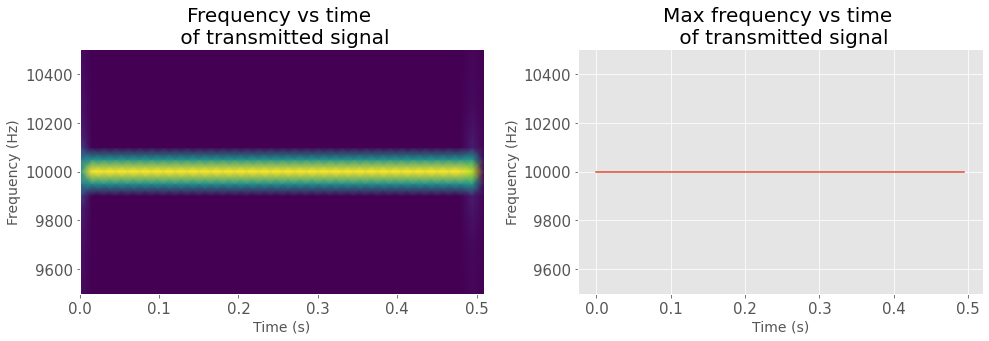

In [2]:
title1 = 'Frequency vs time \n of transmitted signal'
title2 = 'Max frequency vs time \n of transmitted signal'
time_points, max_frequency = plot_frequency_vs_time('Transmit_1.wav', window_length = 2000, frame_overlap=500, ylim=[9500,10500], title1 = title1, title2=title2)

# Shotput

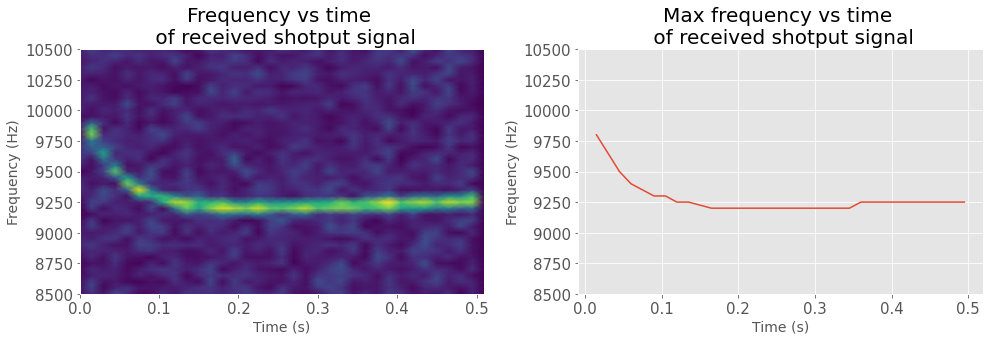

In [3]:
title1 = 'Frequency vs time \n of received shotput signal'
title2 = 'Max frequency vs time \n of received shotput signal'
time_points, max_freq = plot_frequency_vs_time('Shotput_receive_1.wav', window_length = 2000, frame_overlap=500, ylim=[8500,10500],title1 = title1, title2=title2)

## Shotput radial velocity:

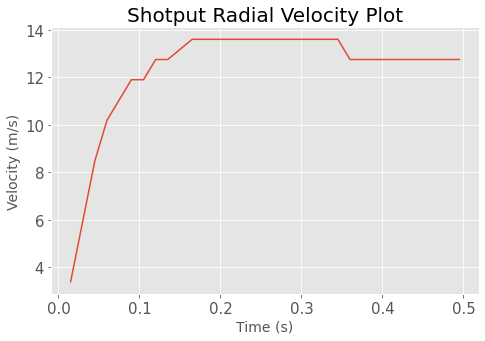

In [4]:
title = 'Shotput Radial Velocity Plot'
time_points, v_radial = plot_radial_velocity(time_points, max_freq , f_source = 10000, title=title)

In [5]:
#Find the velocity at t==0.2:
t_0_2 = [point for point in time_points if (point >0.19 and point < 0.21)]
index = np.where(time_points == t_0_2[0])[0]
print("Shotput Radial Velocity at t=0.2: is {} m\s".format(v_radial[index[0]]))

Shotput Radial Velocity at t=0.2: is 13.6 m\s


# Shotput initial velocity

![alt text](problemAnnotation.png)
Assume at $t > 0.2$ seconds, that $d_{x} >> d_{sensor}$ such that the $\theta$ is large and the radial velocity is approximately equal to the velocity in the direction of the throw. 
Also assume that the deceleration in the first 0.2 seconds is negligible, such that the velocity at t==0.2 seconds is approximately the same as the initial velocity. 

### Therefore, the initial velocity of the shotput is approximately 13.6 m\s.

# Distance of sonic sensor from thrower

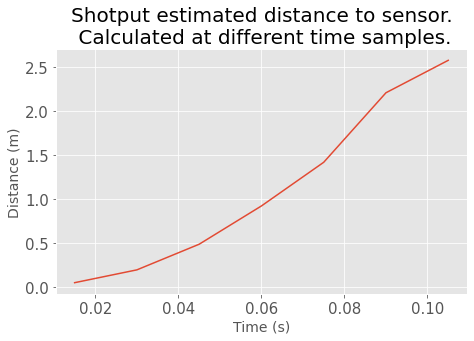

In [6]:
title = "Shotput estimated distance to sensor.\n Calculated at different time samples."
plot_approximate_distance(time_points, v_radial, v_initial=13.6, interval = [0.01, 0.12], title = title)

### Due to assumtion that $d_{x} >> d_{sensor}$ at $t>0.2$ (and therefore $\theta \approx \frac{\pi}{2}$ ), distance estimates at earlier time samples should be more accurate. Therefore, the distance to the sensor is estimated to be between 0.1 and 1 meters.

# Javelin

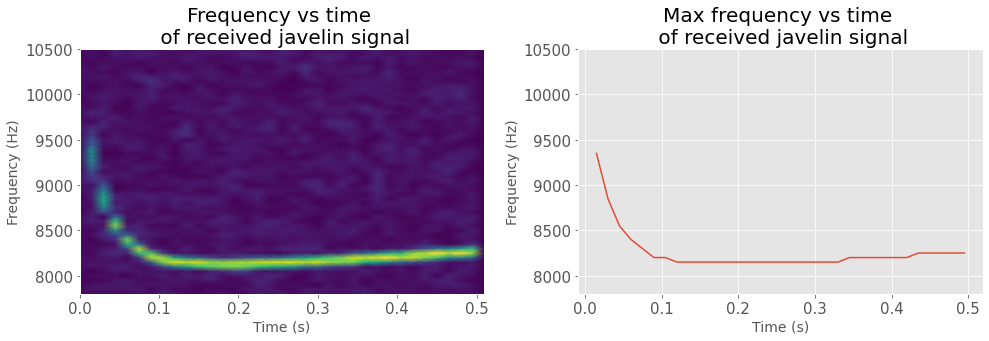

In [7]:
title1 = 'Frequency vs time \n of received javelin signal'
title2 = 'Max frequency vs time \n of received javelin signal'
time_points, max_freq = plot_frequency_vs_time('Javelin_receive_1.wav', window_length = 2000, frame_overlap=500, ylim=[7800, 10500], title1=title1, title2=title2)

# Javelin radial velocity

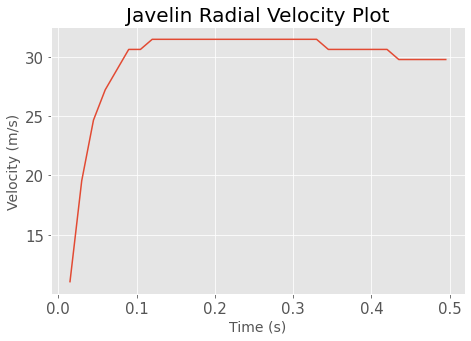

In [8]:
title = 'Javelin Radial Velocity Plot'
time_points, v_radial = plot_radial_velocity(time_points, max_freq, f_source = 10000, title=title)

In [9]:
#Find the velocity at t==0.2:
t_0_2 = [point for point in time_points if (point >0.19 and point < 0.21)]
index = np.where(time_points == t_0_2[0])[0]
print("Javelin Radial Velocity at t=0.2: is {} m\s".format(v_radial[index[0]]))

Javelin Radial Velocity at t=0.2: is 31.45 m\s


## Initial javelin velocity = 31.45 m\s

# Distance of sonic sensor from thrower

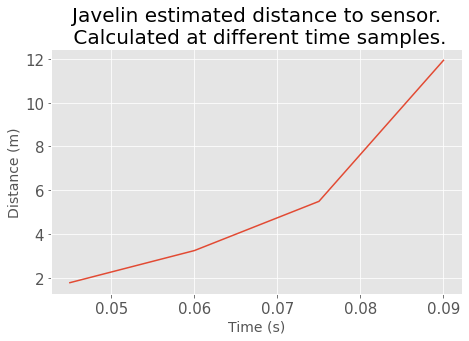

In [10]:
title = "Javelin estimated distance to sensor.\n Calculated at different time samples."
plot_approximate_distance(time_points, v_radial, v_initial=31.45, interval = [0.03, 0.1], title = title)